**Problem Definition**

Classification of the weather image into one of the following classes

1. Sunrise
2. Shine
3. Rain
4. Cloudy

**Data**

[Dataset](https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset)

1. The dataset contains images of corresponding to the Sunrise, Shine, Rain, Cloudy weather conditions
2. Class Distribution
    1. Sunrise - 357 
    2. Shine - 253
    3. Rain - 215
    4. Clody - 300
3. The updated folder structure of the dataset facilitate the data load prodecure

Data Publication
1. The dataset was published on [Mendeley Data](https://data.mendeley.com/datasets/4drtyfjtfy/1)
2. Cite: Ajayi, Gbeminiyi (2018), Multi-class Weather Dataset for Image Classification, Mendeley Data, v1
3. [DOI](http://dx.doi.org/10.17632/4drtyfjtfy.1)
4. Published: 2018-09-13
5. Institutions: University of South Africa - Science Campus
6. Licence: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)


**Evaluation**

Accuracy

**Modelling**

Fully Convolutional Network (FCN)

In [1]:
# Importing necessary libraries

import tensorflow as tf
from tensorflow import keras

import numpy as np
import os
import shutil
import matplotlib.pyplot as plt

In [ ]:
# Splitting the data into train(80%), validation(10%), test(10%)

source_path = 'data/Weather'
classes = ['Cloudy', 'Rain', 'Shine', 'Sunrise']

for weather_class in classes:
    os.makedirs(source_path + '/Train/' + weather_class)
    os.makedirs(source_path + '/Val/' + weather_class)
    os.makedirs(source_path + '/Test/' + weather_class)
    
    file_names = os.listdir(source_path + '/' + weather_class)
    np.random.shuffle(file_names)
    
    train_file_names, val_file_names, test_file_names = np.split(file_names, [int(len(file_names) * (0.8)), int(len(file_names) * (0.9))])
    
    train_file_names = [source_path + '/' + weather_class + '/' + name for name in train_file_names.tolist()]
    val_file_names = [source_path + '/' + weather_class + '/' + name for name in val_file_names.tolist()]
    test_file_names = [source_path + '/' + weather_class + '/' + name for name in test_file_names.tolist()]
    
    
    for name in train_file_names:
        shutil.move(name, source_path + '/train/' + weather_class)
        
    for name in val_file_names:
        shutil.move(name, source_path + '/val/' + weather_class)
        
    for name in test_file_names:
        shutil.move(name, source_path + '/test/' + weather_class)
        
    shutil.rmtree(source_path + '/' + weather_class)


# Initial End-to-End Workflow (Start)

In [12]:
# tf.keras.utils.image_dataset_from_directory is reshaping the data

# train_ds = tf.keras.utils.image_dataset_from_directory(
#     'data/Weather/Train',
#     batch_size=None
# )

Found 899 files belonging to 4 classes.


In [2]:
train_ds = tf.data.Dataset.list_files('data/Weather/Train/*/*')

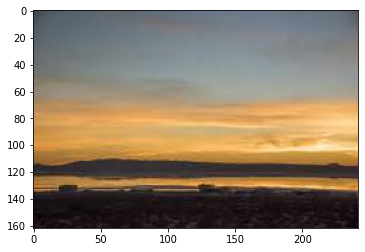

In [3]:
raw = tf.io.read_file('data/Weather/Train/Sunrise/sunrise304.jpg')
img = tf.image.decode_jpeg(raw, channels=3)
plt.imshow(img)

In [4]:
tf.equal(tf.constant(b'Cloudy', dtype='string'), b'Cloudy')

<tf.Tensor: shape=(), dtype=bool, numpy=True>

Minimum Aspect Ratio (Height/Width) of images must be greater than 0.4 for producing better resized images

In [11]:
label_map = {b'Cloudy': tf.constant([1, 0, 0, 0]), 
             b'Rain': tf.constant([0, 1, 0, 0]), 
             b'Shine': tf.constant([0, 0, 1, 0]), 
             b'Sunrise': tf.constant([0, 0, 0, 1])}

f0 = lambda : tf.constant([1, 0, 0, 0])
f1 = lambda : tf.constant([0, 1, 0, 0])
f2 = lambda : tf.constant([0, 0, 1, 0])
f3 = lambda : tf.constant([0, 0, 0, 1])

def get_image_label(file_path):
    label = tf.strings.split(file_path, os.sep)[-2]
    
    label_int = tf.case([(tf.equal(label, b'Cloudy'), f0),
                         (tf.equal(label, b'Rain'), f1),
                         (tf.equal(label, b'Shine'), f2),
                         (tf.equal(label, b'Sunrise'), f3)
                        ])
    
    raw = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(raw, channels=3)
    img = img/255
    
    if (tf.shape(img)[0] < 150 or tf.shape(img)[1] < 150):
        img = tf.image.resize(img, [256, 256], preserve_aspect_ratio=True)
        
    return img, label_int

train_ds = tf.data.Dataset.list_files('data/Weather/Train/*/*')

train_labeled_ds = train_ds.map(get_image_label)

In [12]:
train_ds = tf.data.Dataset.list_files('data/Weather/Train/*/*')

train_labeled_ds = train_ds.map(get_image_label)

In [94]:
for i in train_labeled_ds.take(1):
    sample_inst = i

(<matplotlib.image.AxesImage at 0x15b469731f0>,
 <tf.Tensor: shape=(4,), dtype=int32, numpy=array([0, 1, 0, 0])>)

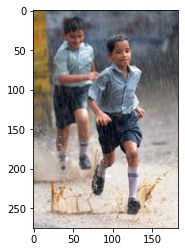

In [95]:
plt.imshow(sample_inst[0]), sample_inst[1]

In [96]:
sample_inst[0].shape

TensorShape([275, 183, 3])

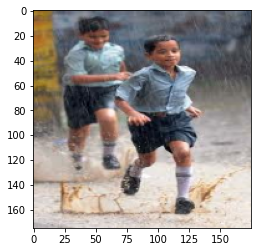

In [97]:
plt.imshow(tf.image.resize(sample_inst[0], [175, 175]))

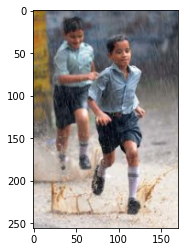

In [98]:
plt.imshow(tf.image.resize(sample_inst[0], [256, 256], preserve_aspect_ratio=True))

In [17]:
train_ds = tf.data.Dataset.list_files('data/Weather/Train/*/*')
val_ds = tf.data.Dataset.list_files('data/Weather/Val/*/*')
test_ds = tf.data.Dataset.list_files('data/Weather/Test/*/*')

train_labeled_ds = train_ds.map(get_image_label)
val_labeled_ds = val_ds.map(get_image_label)
test_labeled_ds = test_ds.map(get_image_label)

In [83]:
# Define the FCN

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(None, None, 3)))
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
# model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
# model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
# model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
# model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
# model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(keras.layers.Conv2D(64, (1, 1), padding='same', activation='relu'))
model.add(keras.layers.Conv2D(4, (1, 1), padding='valid'))
model.add(keras.layers.GlobalMaxPool2D())
model.add(keras.layers.Activation('softmax'))

In [84]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, None, None, 32)    896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, None, None, 32)   0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, None, None, 4)     132       
                                                                 
 global_max_pooling2d_5 (Glo  (None, 4)                0         
 balMaxPooling2D)                                                
                                                                 
 activation_5 (Activation)   (None, 4)                 0         
                                                                 
Total params: 1,028
Trainable params: 1,028
Non-traina

In [85]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
dataset = tf.data.Dataset.from_tensor_slices(np.array([np.random.randint(1, 10, (3, 3, 3)) for _ in range(4)]))
[i for i in list(dataset.batch(1))]

[<tf.Tensor: shape=(1, 3, 3, 3), dtype=int32, numpy=
 array([[[[2, 4, 2],
          [2, 5, 7],
          [2, 6, 4]],
 
         [[5, 6, 2],
          [8, 7, 4],
          [6, 8, 2]],
 
         [[8, 4, 8],
          [5, 9, 4],
          [5, 1, 1]]]])>,
 <tf.Tensor: shape=(1, 3, 3, 3), dtype=int32, numpy=
 array([[[[7, 2, 5],
          [5, 1, 5],
          [8, 7, 6]],
 
         [[2, 8, 8],
          [4, 7, 6],
          [3, 8, 4]],
 
         [[6, 8, 7],
          [8, 8, 1],
          [3, 7, 4]]]])>,
 <tf.Tensor: shape=(1, 3, 3, 3), dtype=int32, numpy=
 array([[[[2, 4, 6],
          [1, 3, 7],
          [8, 3, 2]],
 
         [[9, 9, 1],
          [8, 5, 2],
          [1, 5, 1]],
 
         [[2, 1, 8],
          [5, 9, 5],
          [8, 5, 6]]]])>,
 <tf.Tensor: shape=(1, 3, 3, 3), dtype=int32, numpy=
 array([[[[6, 7, 4],
          [3, 6, 3],
          [8, 6, 1]],
 
         [[4, 9, 4],
          [3, 5, 2],
          [8, 6, 4]],
 
         [[4, 5, 3],
          [2, 8, 7],
          [1, 

In [41]:
for i in dataset.batch(1).as_numpy_iterator():
    print(i.shape)

(1, 3, 3, 3)
(1, 3, 3, 3)
(1, 3, 3, 3)
(1, 3, 3, 3)


In [42]:
train_labeled_ds_batch_iter = train_labeled_ds.batch(1).as_numpy_iterator()

In [72]:
train_labeled_ds.take()

<tf.Tensor: shape=(), dtype=int64, numpy=899>

In [86]:
model.fit(train_labeled_ds_batch_iter)

     47/Unknown - 8s 141ms/step - loss: 1.4060 - accuracy: 0.1702

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_5/conv2d_36/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "S:\Anaconda\envs\tf-gpu\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "S:\Anaconda\envs\tf-gpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "S:\Anaconda\envs\tf-gpu\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "S:\Anaconda\envs\tf-gpu\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "S:\Anaconda\envs\tf-gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\sathw\AppData\Local\Temp\ipykernel_10376\1882351417.py", line 1, in <cell line: 1>
      model.fit(train_labeled_ds_batch_iter)
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 893, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 537, in minimize
      grads_and_vars = self._compute_gradients(
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 590, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "S:\Anaconda\envs\tf-gpu\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 471, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_5/conv2d_36/Conv2D/Conv2DBackpropInput'
OOM when allocating tensor with shape[1,32,1226,1750] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_5/conv2d_36/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_10120]

Out of Memory occurs even for the simple models with batchs of size = 1

# Initial End-to-End Workflow (End)